Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

d:\anaconda\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Подготовка данных

In [ ]:
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:

dataset = load_dataset('imdb')

In [ ]:
from tqdm import tqdm

print('Start tokenize...')
sentences = [sent for x in tqdm(dataset['train']['text']) for sent in sent_tokenize(x, language='english')]
print('End tokenize')
print(f"Количество предложений : {len(sentences)}")

word_threshold = 32
print('Start filter...')
sentences = [s for s in tqdm(sentences) if len(word_tokenize(s)) < word_threshold]
print('End filter')
print(f"Итог : {len(sentences)}")


Start tokenize...


100%|██████████| 25000/25000 [00:08<00:00, 2794.30it/s]


End tokenize
Количество предложений : 271057
Start filter...


100%|██████████| 271057/271057 [00:31<00:00, 8692.11it/s]

End filter
Итог : 198801


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

tokenized_to_word = []

for query in tqdm(sentences):
    tokenized_to_word.append(word_tokenize(query))

tokenized_to_word = [item for row in tokenized_to_word for item in row]

for word in tokenized_to_word:
    words[word] +=1




100%|██████████| 198801/198801 [00:16<00:00, 11810.03it/s]


In [ ]:
len(words)

81380

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_size = 40000
for item in tqdm(words.most_common(vocab_size)):
    vocab.add(item[0])





100%|██████████| 40000/40000 [00:00<00:00, 1333302.82it/s]


In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split() ]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# eval

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

###Train loop



In [ ]:
def train_model(model, epochs, criterion, optimizer):
    losses = []
    perplexity = []
    print('Start training...\n\n')
    for epoch in range(epochs):
        model.train()
        epoch_loss = []
        for batch in tqdm(train_dataloader, desc=f'start training with epoch : {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        losses.append(sum(epoch_loss) / len(epoch_loss))
        perplexity.append(evaluate(model, criterion, eval_dataloader))

    return losses, perplexity




### Бейслайн


In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size=len(vocab), num_layers=1):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.foa = nn.Tanh()
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(p=0.2)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.gru(embeddings)
        output = self.linear(self.foa(output))
        output = self.dropout(self.foa(output))
        output = self.projection(output)
        return output

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


In [ ]:
loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)

Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [01:54<00:00, 10.90it/s]


Построим графики лоса и перплексии на валидационном датасете для каждой эпохи

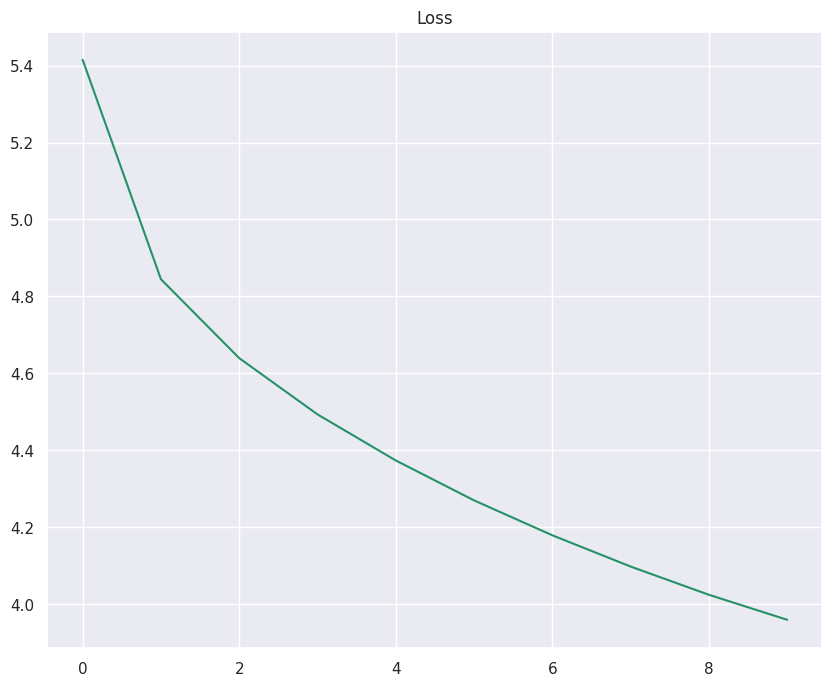

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title('Loss')
plt.plot(np.arange(10), loss)

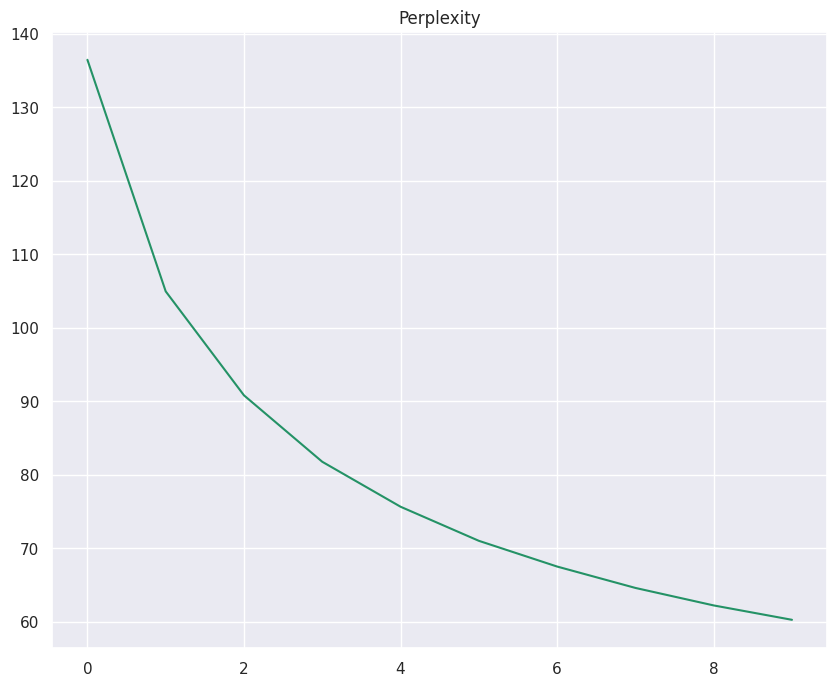

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('Perplexity')
plt.plot(np.arange(10), perplexity)

Посмотрим перплексию на тестовой выборке, отметим как бейслайн

In [ ]:
output = evaluate(model, criterion, test_dataloader)
print(output)

60.134383448302515


# Эксперименты

Теперь попробуем увеличить количество слоев gru до 2

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


In [ ]:
loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)

Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [01:58<00:00, 10.48it/s]


In [ ]:
test_perplexity = evaluate(model=model, criterion=criterion, dataloader=test_dataloader)
test_perplexity

77.5760474333892

Видим, что это только ухудшило результат. Попробуем увеличить hidden_size и p в dropout, а также увеличим lr для улучшения сходимости, посмотрим даст ли результат.

In [ ]:
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(lr=0.009, params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)

Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [03:17<00:00,  6.30it/s]


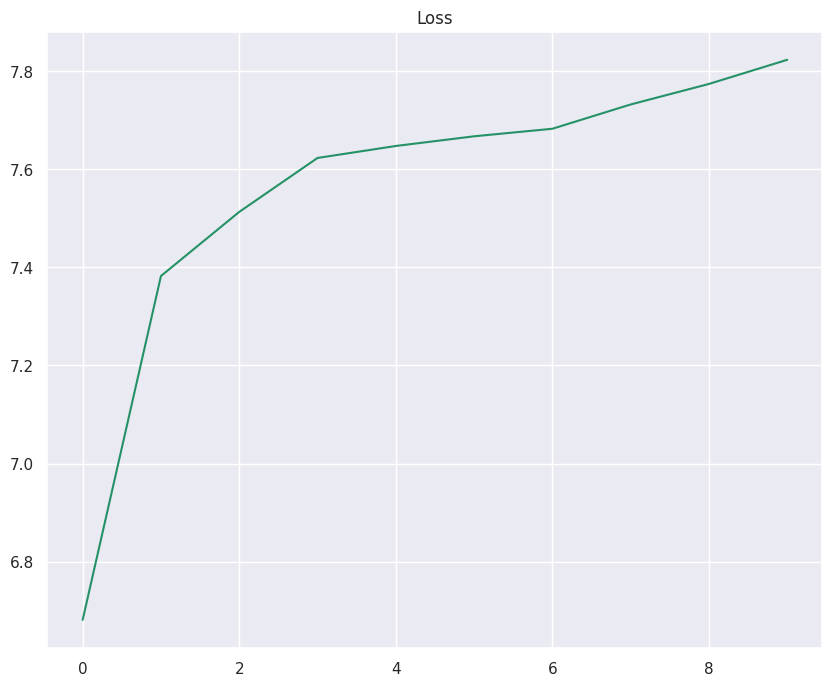

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('Loss')
plt.plot(np.arange(10), loss)

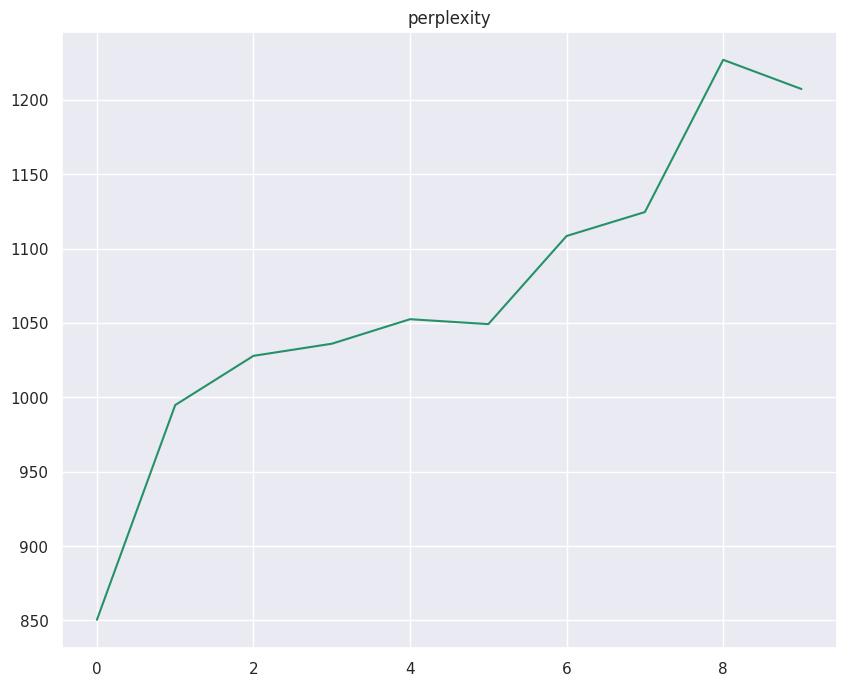

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('perplexity')
plt.plot(np.arange(10), perplexity)

In [ ]:
test_p = evaluate(model, criterion, test_dataloader)
test_p

1211.6281263039687

Видим, что модель не обучается, попробуем архитектуру lstm и adamw

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size=len(vocab), num_layers=1):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.foa = nn.Tanh()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.linear(self.foa(output))
        output = self.dropout(self.foa(output))
        output = self.projection(output)
        return output

In [ ]:
model = LSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


In [ ]:
loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)

Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [01:55<00:00, 10.75it/s]


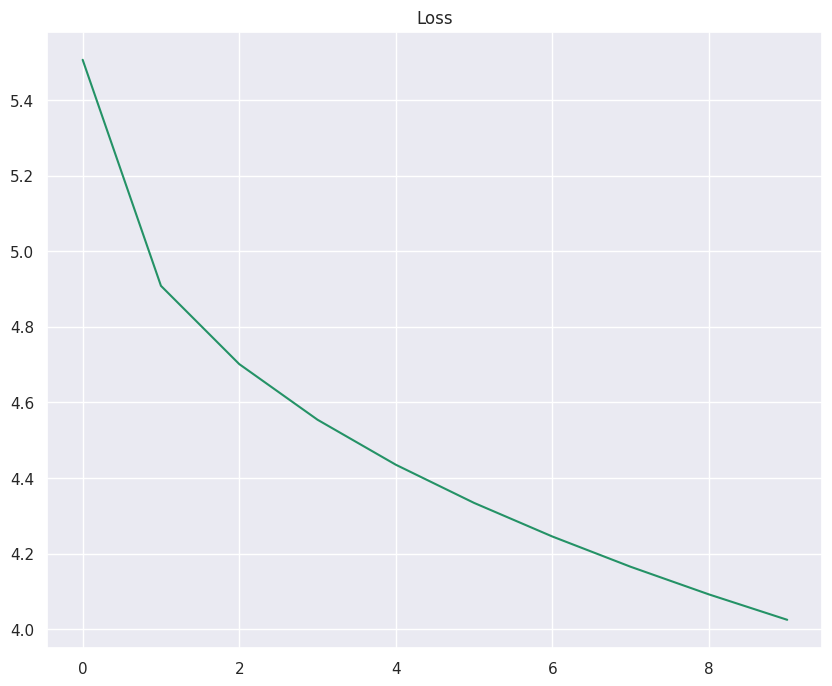

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('Loss')
plt.plot(np.arange(10), loss)

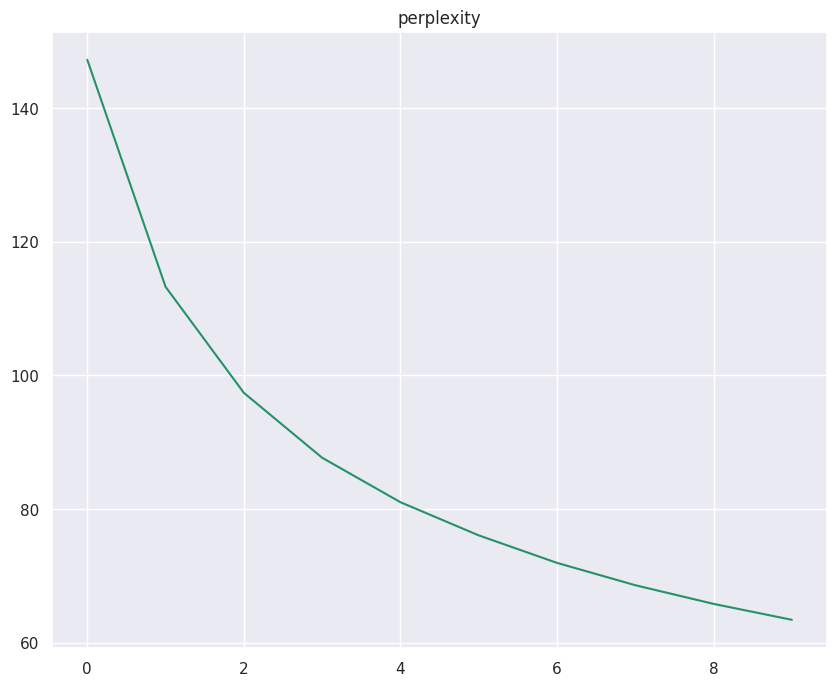

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('perplexity')
plt.plot(np.arange(10), perplexity)

In [ ]:
test_perplexity = evaluate(model, criterion, test_dataloader)
test_perplexity

Уже лучше, видим что почти приблизились к бейслайну ). Попробуем увеличить hiiden_dim и количество слоев.

In [ ]:
model = LSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


In [ ]:
loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)

Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [03:42<00:00,  5.60it/s]


In [ ]:
test_perplexity = evaluate(model, criterion, test_dataloader)

In [ ]:
test_perplexity

55.49052197960813

Видим что перплексия стала ниже. Попробуем добавить эмбэддингам выразительности, применим линейный слой до подачи в lstm слой.

In [ ]:
class UpLSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size=len(vocab), num_layers=1):
        super().__init__()

        self.pre_embeddings = nn.Linear(hidden_dim, hidden_dim)
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.foa = nn.Tanh()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.dropout = nn.Dropout(p=0.1)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embeddings(input_batch)
        embeddings = self.pre_embeddings(embeddings)
        embeddings = self.foa(embeddings)

        output, _ = self.lstm(embeddings)
        output = self.linear(self.foa(output))
        output = self.dropout(self.foa(output))
        output = self.projection(output)
        return output

In [ ]:
model = UpLSTM(hidden_dim=512, vocab_size=len(vocab), num_layers=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

loss, perplexity = train_model(model, epochs=10, criterion=criterion, optimizer=optimizer)


Start training...




start training with epoch : 9: 100%|██████████| 1243/1243 [20:51<00:00,  1.01s/it]


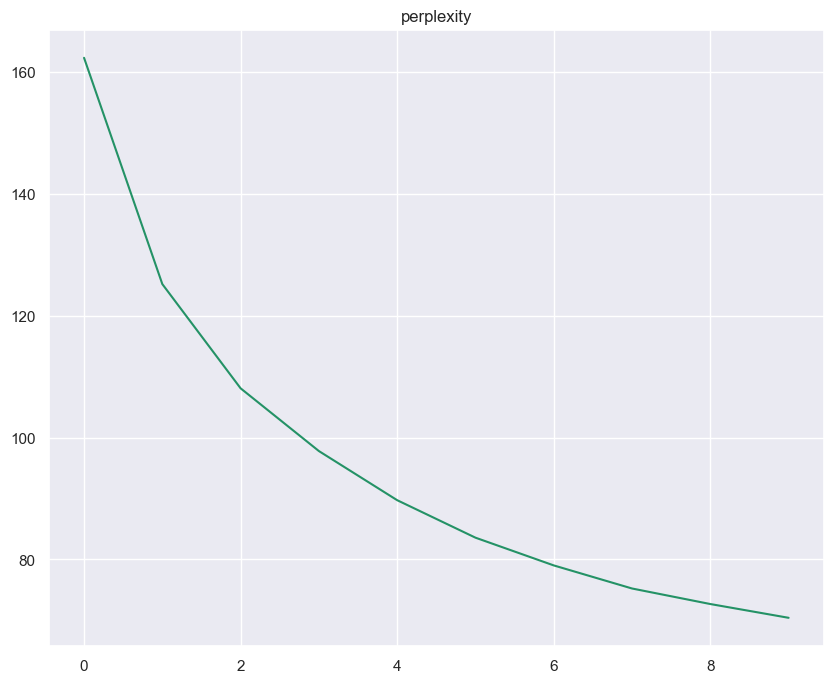

In [ ]:

plt.figure(figsize=(10, 8))
plt.title('perplexity')
plt.plot(np.arange(10), perplexity)

In [ ]:
test_perplexity = evaluate(model, criterion, test_dataloader)

In [ ]:
test_perplexity

70.3263045204192

# Выводы

В итоге лучшая перплексия на тестовой выборке 55.49 для словаря размером 40к это весьма неплохо, архитектура на которой она была получена:
 LSTM c hidden_dim=512, num_layers=2.

Optimizer: AdamW, lr=0.001, weight_decay=0.01.

Также неплохо себя показала GRU с 1 слоем и hidden_size=256.

Размер батча увеличивать не стал, чтобы обучение не было уж слишком долгим.


# Генерация

In [ ]:


def generate_sequence(start_seq, model, max_seq_length, top_p=0.9, device='cpu'):
    start_tokens = start_seq.split() if isinstance(start_seq, str) else start_seq
    start_tokenize = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in start_tokens]
    input_ids = torch.LongTensor(start_tokenize).unsqueeze(0).to(device)

    model.to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(max_seq_length):
            logits = model(input_ids)
            next_logits = logits[:, -1, :]

            probs = torch.softmax(next_logits, dim=-1)

            sorted_probs, sorted_indices = torch.sort(probs, descending=True)

            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

            mask = cumulative_probs <= top_p
            mask[:, 0] = True

            filtered_probs = sorted_probs * mask.float()
            filtered_probs = filtered_probs / filtered_probs.sum(dim=-1, keepdim=True)

            next_char = torch.multinomial(filtered_probs, num_samples=1)
            next_char_idx = sorted_indices.gather(-1, next_char)

            input_ids = torch.cat([input_ids, next_char_idx], dim=1)

            if next_char_idx.item() == word2ind['<eos>']:
                break

    return ' '.join(ind2word[idx.item()] for idx in input_ids[0])

In [ ]:
generate_sequence('We believe', model=model, max_seq_length=150)

'<bos> We believe that how random police guy probably would be influenced by Cher and <unk> <unk> the actors they were <unk> <eos>'